# Análisis de Comportamiento del Usuario de Empresa de Productos Alimenticios 

## Información de la Data 

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

**Descripción de los datos**

Cada entrada de registro es una acción de usuario o un evento.

- **EventName:** nombre del evento.
- **DeviceIDHash:** identificador de usuario unívoco.
- **EventTimestamp:** hora del evento.
- **ExpId:** número de experimento. 246 y 247 son los grupos de control, y 248 es el grupo de prueba.

## Integrando Data

Importamos las librerías necesarias 

In [1]:
import pandas as pd
from datetime import datetime
from scipy import stats as st
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates


## Paso 1. Abrir el archivo de datos y leer la información general



In [2]:
# Se cargan los datos empleando la librería pandas:
logs = pd.read_csv('/datasets/logs_exp_us.csv',
                   engine = 'python',
                   sep = '\s', header = 0,
                   dtype = {'EventName': 'category', 'ExpId': 'category'},)

In [3]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   EventName       244126 non-null  category
 1   DeviceIDHash    244126 non-null  int64   
 2   EventTimestamp  244126 non-null  int64   
 3   ExpId           244126 non-null  category
dtypes: category(2), int64(2)
memory usage: 4.2 MB


**Observaciones :**

**EventName:** nombre del evento registrado. Tipo de dato: category. Sin valores nulos.

**DeviceIDHash:** Tipo de dato: int64.

**EventTimestamp:**  Tipo de dato: int64.Tiene datos tipo object.

**ExpId:** identificador del experimento (grupo A/B). Tipo de dato: category.

- No hay valores nulos en ninguna de las columnas.
- Cambiar el nombre de las variables con letras solo minúsculas.
- Los nombres de las columnas no tienen separadores de palabras.


## Paso 2. Preparar los datos para el análisis



- Cambia el nombre de las columnas de manera que sea conveniente para ti.
- Comprueba los tipos de datos y valores ausentes. Corrige los datos si es necesario.
- Agrega una columna de fecha y hora y una columna separada para las fechas.

**Cambiamos los nombres de las columnas de manera correcta, en minúsculas y con guión bajo para separar las frases .**

In [4]:
logs.rename(columns = {'EventName': 'event_name',
                       'DeviceIDHash': 'user_id',
                       'EventTimestamp': 'full_date',
                       'ExpId': 'group'}, inplace = True)

**Contamos los valores ausentes**

In [5]:
logs.isna().sum().reset_index()

,index,0
0,event_name,0
1,user_id,0
2,full_date,0
3,group,0


No existen valores ausentes en las columnas . 

**Contar si hay filas publicadas**

In [6]:
print('Hay un total de', logs.duplicated().sum(), 'filas duplicadas.')

Hay un total de 413 filas duplicadas.


**Comprobar si existen realmente filas duplicadas o es un error del sistema**



In [7]:
logs[logs.duplicated()]

,event_name,user_id,full_date,group
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4076,MainScreenAppear,3761373764179762633,1564631266,247
4803,MainScreenAppear,2835328739789306622,1564634641,248
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,1565206004,247
242332,PaymentScreenSuccessful,4718002964983105693,1565206005,247
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246
242362,CartScreenAppear,2382591782303281935,1565206049,246


In [8]:
logs.drop_duplicates(inplace = True)
logs.reset_index(inplace = True, drop = True)

In [9]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   event_name  243713 non-null  category
 1   user_id     243713 non-null  int64   
 2   full_date   243713 non-null  int64   
 3   group       243713 non-null  category
dtypes: category(2), int64(2)
memory usage: 4.2 MB


Si existen filas duplicadas y para un mejor manejo, las eliminamos.

**Cambiar *full_date* a tipo datetime**

In [10]:
logs['full_date'] = pd.to_datetime(logs['full_date'], unit = 's')

**Añadir la columna de fecha y hora**

In [11]:
# Agregar una columna con la fecha del evento:
logs['date'] = logs['full_date'].dt.date
# Agregar una columna con la hora del evento:
logs['hour'] = logs['full_date'].dt.time

## Paso 3. Estudiar y comprobar los datos

### ¿Cuántos eventos hay en los registros?

In [12]:

print('En los regristros hay un total de', logs['event_name'].nunique(), 'eventos.')

En los regristros hay un total de 5 eventos.


### ¿Cuántos usuarios hay en los registros?

In [13]:
print('En los registros hay un total de', logs['user_id'].nunique(), 'usuarios únicos.')

En los registros hay un total de 7551 usuarios únicos.


### ¿Cuántos usuarios hay en los registros?

In [14]:
print('El promedio de eventos por usuario es', (logs.groupby('user_id')['event_name'].count().mean()).round(3),'.')


El promedio de eventos por usuario es 32.276 .


### ¿Cuál es el promedio de eventos por usuario?

In [15]:
print('Los datos cubren registros desde el', logs['date'].min(), 'hasta el', logs['date'].max(),'.')

Los datos cubren registros desde el 2019-07-25 hasta el 2019-08-07 .


Esto quiere decir que todos lo valores corresponden a un lapso de 2 semanas.



### ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. 

In [16]:
#Calcular el periodo de tiempo  que cubren, los datos obteniendo la fecha mínima y máxima . 
fecha_minima = logs['full_date'].min()
fecha_maxima = logs['full_date'].max()

print(f"El periodo cubierto por los datos va desde {fecha_minima} hasta {fecha_maxima}.")

El periodo cubierto por los datos va desde 2019-07-25 04:43:36 hasta 2019-08-07 21:15:17.


### Traza un histograma por fecha y hora. 

In [17]:
# Crear columna truncada a la hora (incluye fecha + hora, sin minutos ni segundos)
logs['full_hour'] = logs['full_date'].dt.floor('H')


In [18]:
# Crear la figura y graficar
plt.figure(figsize=(16, 6))
plt.bar(eventos_por_hora['full_hour'], eventos_por_hora['event_count'], width=0.03)

# Etiquetas y título
plt.xlabel('Fecha y Hora')
plt.ylabel('Cantidad de eventos')
plt.title('Histograma de eventos por hora')

# Formatear el eje X para mostrar fecha + hora
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Mostrar una etiqueta cada 6 horas (puedes ajustar el intervalo)
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))

# Rotar etiquetas para que no se amontonen
plt.xticks(rotation=45)

# Ajustar el diseño para que todo se vea bien
plt.tight_layout()
plt.show()


NameError: name 'eventos_por_hora' is not defined

<Figure size 1600x600 with 0 Axes>

### ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?


Se trazó un histograma por fecha y hora para analizar la cobertura y calidad temporal del dataset.

- Se detectó que entre el **24 y el 30 de julio de 2019**, los datos son escasos y no confiables.
- A partir del **31 de julio de 2019**, la actividad por hora se estabiliza y se vuelve representativa del comportamiento real de los usuarios.
- Por tanto, el periodo confiable para el análisis es del **31 de julio al 7 de agosto de 2019**.
- Se ignorará el periodo anterior al 31 de julio para evitar sesgos en los resultados.


In [19]:
#Filtrar los datos necesarios para el análisis.
filtred_logs = logs[logs['full_date'] >= pd.to_datetime('2019-07-31')].reset_index(drop = True)

### ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

1. Comparar el número total de eventos antes y después.


In [20]:
eventos_antes = logs.shape[0]
eventos_despues = filtred_logs.shape[0]

print(f"Eventos antes del filtrado: {eventos_antes}")
print(f"Eventos después del filtrado: {eventos_despues}")
print(f"Eventos eliminados: {eventos_antes - eventos_despues} ({(eventos_antes - eventos_despues)/eventos_antes:.2%})")


Eventos antes del filtrado: 243713
Eventos después del filtrado: 242917
Eventos eliminados: 796 (0.33%)


2. Comparar la cantidad de usuarios únicos antes y después.


In [21]:
usuarios_antes = logs['user_id'].nunique()
usuarios_despues = filtred_logs['user_id'].nunique()

print(f"Usuarios antes del filtrado: {usuarios_antes}")
print(f"Usuarios después del filtrado: {usuarios_despues}")
print(f"Usuarios eliminados: {usuarios_antes - usuarios_despues} ({(usuarios_antes - usuarios_despues)/usuarios_antes:.2%})")


Usuarios antes del filtrado: 7551
Usuarios después del filtrado: 7542
Usuarios eliminados: 9 (0.12%)


#### ¿Se perdieron muchos eventos y usuarios al excluir los datos más antiguos?
La pérdida de datos fue mínima, tanto en cantidad de eventos como en usuarios.Los eventos excluidos representaban un volumen muy bajo y probablemente estaban incompletos o desorganizados.l pequeño número de usuarios eliminados corresponde a aquellos que interactuaron únicamente antes del 31 de julio y no participaron durante el periodo estable. Excluir los primeros días no afecta negativamente el análisis, garantiza que trabajamos con datos confiables y representativos del comportamiento real de los usuarios.


### Asegúrate de tener usuarios de los tres grupos experimentales.

In [22]:
# Revisar los valores únicos en la columna 'group'
print(filtred_logs['group'].unique())

# Ver cuántos usuarios únicos hay en cada grupo
filtred_logs.groupby('group')['user_id'].nunique()


['247', '248', '246']
Categories (3, object): ['247', '248', '246']


group
246    2485
247    2517
248    2540
Name: user_id, dtype: int64

Se comprobó la presencia de los tres grupos experimentales en el conjunto de datos filtrado:

- Grupo 246 (Control A): 2485 usuarios

- Grupo 247 (Control A): 2517 usuarios

- Grupo 248 (Grupo de prueba B): 2540 usuarios

Es decir que, todos los grupos están presentes los tamaños de muestra entre grupos son similares, lo cual es ideal para realizar una comparación justa en el análisis A/A/B. Los grupos 246 y 247 (ambos control) tienen tamaños comparables, lo que permitirá verificar que no hay sesgo antes de comparar con el grupo 248.

## Paso 4. Estudiar el embudo de eventos

### Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [23]:
# Contar frecuencia de cada evento
eventos_frecuencia = filtred_logs['event_name'].value_counts()

# Mostrar resultados
eventos_frecuencia


MainScreenAppear           118578
OffersScreenAppear          46707
CartScreenAppear            42560
PaymentScreenSuccessful     34058
Tutorial                     1014
Name: event_name, dtype: int64

El evento **más frecuente** es `MainScreenAppear`, lo que indica que la mayoría de usuarios ingresan a la pantalla principal.

### Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios. Calcula la proporción de usuarios que realizaron la acción al menos una vez.

In [24]:
# Total de usuarios únicos en el dataset filtrado
total_usuarios = filtred_logs['user_id'].nunique()

# Cantidad de usuarios únicos por evento
usuarios_por_evento = filtred_logs.groupby('event_name')['user_id'].nunique()

# Convertir a DataFrame para mejor manejo
usuarios_por_evento = usuarios_por_evento.reset_index()
usuarios_por_evento.columns = ['event_name', 'user_count']

# Ordenar por cantidad de usuarios, de mayor a menor
usuarios_por_evento = usuarios_por_evento.sort_values(by='user_count', ascending=False)

# Calcular proporción respecto al total de usuarios
usuarios_por_evento['user_proportion'] = usuarios_por_evento['user_count'] / total_usuarios

# Mostrar resultados
usuarios_por_evento


,event_name,user_count,user_proportion
1,MainScreenAppear,7429,0.985017
2,OffersScreenAppear,4606,0.610713
0,CartScreenAppear,3742,0.496155
3,PaymentScreenSuccessful,3542,0.469637
4,Tutorial,845,0.112039


Segun los datos la mayor parte de usuarios vio la pantalla de inicio 98,5% y casi nadie reviso el tutorial 11,20%

### ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

Las acciones presuntamente ocurrieron en este orden : 
- MainScreenAppear: Casi todos los usuarios (98.5%) vieron la pantalla principal. Esto tiene sentido, es la primera acción al abrir la app o sitio.

- OffersScreenAppear: Luego, alrededor del 61% navegó a la pantalla de ofertas. Esto es un paso típico tras la pantalla principal.

- CartScreenAppear: Después, el 49.6% llegó al carrito, indicando que casi la mitad de los usuarios añadieron o vieron productos en el carrito.

- PaymentScreenSuccessful: El 47% completó el pago exitosamente. Es natural que esta cifra sea menor que la del carrito, porque no todos completan la compra.

- Tutorial: Solo el 11.2% utilizó o vio el tutorial, probablemente de forma independiente y no necesariamente en esta secuencia.

**¿Todas son parte de una sola secuencia?**
No necesariamente. Los primeros cuatro eventos parecen formar un embudo típico de compra: desde la llegada a la pantalla principal hasta el pago. La progresión decreciente en la cantidad y proporción de usuarios es coherente con la pérdida de usuarios en cada etapa.


**¿Es necesario tenerlas todas en cuenta para el embudo?**
Para calcular el embudo clásico de conversión, normalmente se consideran los eventos secuenciales relevantes a la compra, es decir:

MainScreenAppear

OffersScreenAppear

CartScreenAppear

PaymentScreenSuccessful

El evento Tutorial es opcional y no se considera parte del embudo, ya que no refleja una etapa directa del flujo de compra.



### Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.

In [25]:
# Calcular la tasa de conversión secuencial entre eventos (A → B → C)
usuarios_por_evento['conversion_rate'] = (
    usuarios_por_evento['user_count'] / usuarios_por_evento['user_count'].shift(1) * 100
).round(2)

# Asignar 100% a la primera fila (ya que no tiene etapa anterior)
usuarios_por_evento['conversion_rate'].fillna(100, inplace=True)

# Mostrar los resultados finales
print("El porcentaje de usuarios que pasan de una etapa a la otra es:")
print(usuarios_por_evento[['event_name', 'conversion_rate']])


El porcentaje de usuarios que pasan de una etapa a la otra es:
                event_name  conversion_rate
1         MainScreenAppear           100.00
2       OffersScreenAppear            62.00
0         CartScreenAppear            81.24
3  PaymentScreenSuccessful            94.66
4                 Tutorial            23.86


Para una mejor visualización cremos un gráfico : 

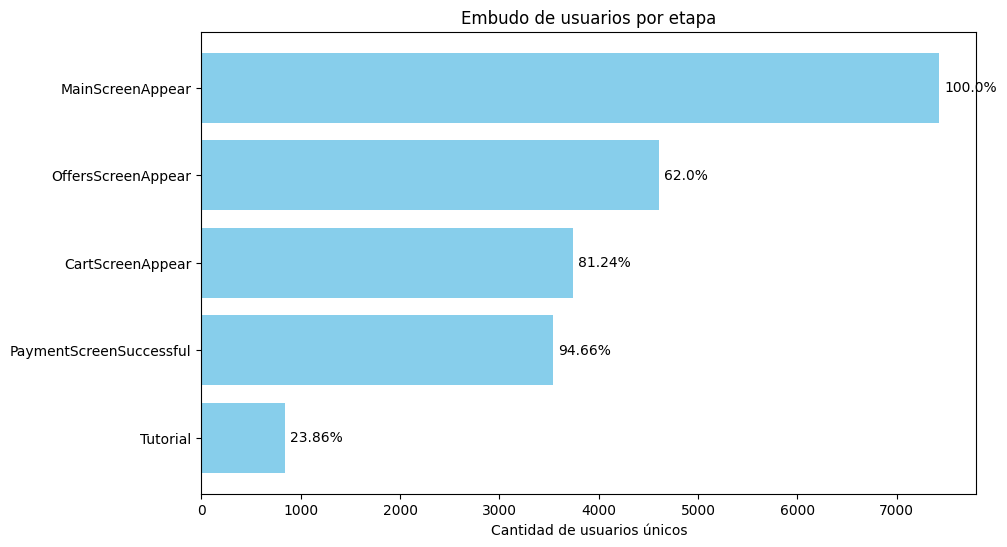

In [26]:
plt.figure(figsize=(10,6))
plt.barh(
    usuarios_por_evento['event_name'],
    usuarios_por_evento['user_count'],
    color='skyblue'
)
plt.xlabel('Cantidad de usuarios únicos')
plt.title('Embudo de usuarios por etapa')

# Mostrar tasa de conversión al lado derecho de cada barra
for i, (count, rate) in enumerate(zip(usuarios_por_evento['user_count'], usuarios_por_evento['conversion_rate'])):
    plt.text(count + 50, i, f'{rate}%', va='center')

plt.gca().invert_yaxis()  # Para que la primera etapa esté arriba
plt.show()

- MainScreenAppear: El 100% de usuarios empiezan aquí, es la entrada a la app.

- OffersScreenAppear: El 62% de usuarios que vieron la pantalla principal llegaron a la pantalla de ofertas. Hay una caída importante aquí, posiblemente algunos usuarios no exploran ofertas.

- CartScreenAppear: El 81.25% de quienes vieron ofertas llegaron a ver el carrito. Esto indica que una mayoría de quienes exploran ofertas agregan productos o ven el carrito.

- PaymentScreenSuccessful: El 94.66% de quienes llegaron al carrito completaron el pago exitosamente, mostrando una alta tasa de conversión final entre carrito y pago.

### ¿En qué etapa pierdes más usuarios?

El embudo muestra que la mayor pérdida de usuarios ocurre en la transición entre la pantalla principal y la pantalla de ofertas.La mayor pérdida de usuarios se da en la transición de MainScreenAppear a OffersScreenAppear, donde solo el 62% de los usuarios que vieron la pantalla principal pasan a la pantalla de ofertas.Aproximadamente un 38% de usuarios abandona o no continúa después de la pantalla principal, lo que representa la caída más significativa en el embudo.

### ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

In [27]:
total_inicio = usuarios_por_evento.loc[usuarios_por_evento['event_name'] == 'MainScreenAppear', 'user_count'].values[0]
total_final = usuarios_por_evento.loc[usuarios_por_evento['event_name'] == 'PaymentScreenSuccessful', 'user_count'].values[0]

porcentaje_completo = (total_final / total_inicio) * 100

print(f"El {porcentaje_completo:.2f}% de usuarios completó todo el viaje desde la pantalla principal hasta el pago exitoso.")


El 47.68% de usuarios completó todo el viaje desde la pantalla principal hasta el pago exitoso.


## Paso 5. Estudiar los resultados del experimento

### ¿Cuántos usuarios hay en cada grupo?

In [28]:
# Calcular Cantidad de usuarios por grupo.
usuarios_por_grupo = filtred_logs.groupby('group')['user_id'].nunique()
usuarios_por_grupo

group
246    2485
247    2517
248    2540
Name: user_id, dtype: int64

La cantidad de usuarios por grupo es bastante equilibrada, con una diferencia máxima de 55 usuarios entre el grupo con más y el que tiene menos.

### Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

En este experimento, los grupos 246 y 247 son grupos de control. El objetivo del test A/A es comprobar que los mecanismos de segmentación y los cálculos de métricas funcionan correctamente, ya que no debería existir una diferencia estadísticamente significativa entre ellos.




In [29]:
# Crear una función para comprar tasas de conversión.
def comparar_tasas_de_conversion(df, grupo_a, grupo_b, evento, alpha):
    # Tamaño total por grupo
    n1 = len(df[df['group'] == grupo_a])
    n2 = len(df[df['group'] == grupo_b])

    # Éxitos por grupo (usuarios que realizaron el evento)
    x1 = len(df[(df['group'] == grupo_a) & (df['event_name'] == evento)])
    x2 = len(df[(df['group'] == grupo_b) & (df['event_name'] == evento)])

    # Proporciones
    p1 = x1 / n1
    p2 = x2 / n2
    p = (x1 + x2) / (n1 + n2)

    # Estadístico Z
    z = (p1 - p2) / mt.sqrt(p * (1 - p) * (1 / n1 + 1 / n2))

    # Valor p (prueba de dos colas)
    valor_p = st.norm.sf(abs(z)) * 2

    # Conclusión
    if valor_p < alpha:
        print(' Se rechaza la hipótesis nula; hay diferencia significativa entre los grupos.\n')
    else:
        print(' Se acepta la hipótesis nula; no hay diferencia significativa entre los grupos.\n')

    # Mostrar resultados
    print(f'Tasa de conversión grupo {grupo_a}: {round(p1 * 100, 2)} %')
    print(f'Tasa de conversión grupo {grupo_b}: {round(p2 * 100, 2)} %\n')
    print(f'Estadístico Z: {round(z, 4)}')
    print(f'Valor p: {valor_p:.4f}')

    return p1, p2, z, valor_p

Para realizar los test me base en la siguiente tabla: 

| Comparación | Propósito                                        |
| ----------- | ------------------------------------------------ |
| 246 vs 247  | Test A/A (verificar el sistema)                  |
| 246 vs 248  | Test A/B (¿tuvo efecto la modificación?)         |
| 247 vs 248  | Test A/B (confirmar desde el otro grupo control) |  

En esta ocasión decidí ejecutar la función con el evento del pago final PaymentScreenSuccessful.

In [30]:
comparar_tasas_de_conversion(filtred_logs, '246', '247', 'PaymentScreenSuccessful', 0.05)


 Se rechaza la hipótesis nula; hay diferencia significativa entre los grupos.

Tasa de conversión grupo 246: 14.88 %
Tasa de conversión grupo 247: 12.9 %

Estadístico Z: 11.4031
Valor p: 0.0000


(0.1488326117965016,
 0.12895502407126122,
 11.403141610165758,
 4.032979161864428e-30)

- Se rechaza la hipótesis nula con un valor p extremadamente pequeño (casi cero), lo que indica que hay una diferencia estadísticamente significativa entre los grupos 246 y 247.

- La tasa de conversión del grupo 246 es mayor que la del grupo 247 por casi 2 puntos porcentuales.

- Esto no es esperado en un test A/A, ya que ambos grupos deberían comportarse igual (o muy similar) porque ninguno tiene modificación.

### Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

*Imprimo los eventos únicos para tenerlos a la mano*

In [31]:
eventos_unicos = filtred_logs['event_name'].unique()
print(eventos_unicos)


['MainScreenAppear', 'OffersScreenAppear', 'Tutorial', 'PaymentScreenSuccessful', 'CartScreenAppear']
Categories (5, object): ['MainScreenAppear', 'OffersScreenAppear', 'Tutorial', 'PaymentScreenSuccessful', 'CartScreenAppear']


*Realizamos una función para determinar el número de usuarios por evento de los grupos de control*

In [32]:
def usuarios_por_evento_en_controles(df, evento):
    grupos = ['246', '247']
    for grupo in grupos:
        total_usuarios = df[df['group'] == grupo]['user_id'].nunique()
        usuarios_evento = df[(df['group'] == grupo) & (df['event_name'] == evento)]['user_id'].nunique()
        proporcion = usuarios_evento / total_usuarios * 100
        print(f"Grupo {grupo}:")
        print(f"  - Usuarios que realizaron '{evento}': {usuarios_evento}")
        print(f"  - Total de usuarios en el grupo: {total_usuarios}")
        print(f"  - Proporción: {round(proporcion, 2)} %\n")


*Primero encontramos la proporción con la función que antes realice y revisamos si es estadisticamente significativa*

**Evento: PaymentScreenSuccessful**

In [33]:
comparar_tasas_de_conversion(filtred_logs, '246', '248', 'PaymentScreenSuccessful', 0.05)


 Se rechaza la hipótesis nula; hay diferencia significativa entre los grupos.

Tasa de conversión grupo 246: 14.88 %
Tasa de conversión grupo 248: 14.24 %

Estadístico Z: 3.7262
Valor p: 0.0002


(0.1488326117965016,
 0.14236481496676787,
 3.7261642370100194,
 0.00019441575277866433)

Se rechaza la hipótesis nula con un valor p = 0.0002, indicando una diferencia estadísticamente significativa entre los grupos 246 y 248.

Sin embargo, la diferencia absoluta en la tasa de conversión es solo de 0.64 puntos porcentuales, que aunque estadísticamente significativa, puede ser poco relevante en la práctica (según contexto de negocio).

Esto indica que el grupo experimental 248 tuvo una tasa de conversión ligeramente menor que el control 246.



In [34]:
comparar_tasas_de_conversion(filtred_logs, '247', '248', 'PaymentScreenSuccessful', 0.05)


 Se rechaza la hipótesis nula; hay diferencia significativa entre los grupos.

Tasa de conversión grupo 247: 12.9 %
Tasa de conversión grupo 248: 14.24 %

Estadístico Z: -7.8888
Valor p: 0.0000


(0.12895502407126122,
 0.14236481496676787,
 -7.888837424069168,
 3.0501455894896457e-15)

Se rechaza la hipótesis nula con un valor p prácticamente cero, indicando una diferencia altamente significativa entre los grupos 247 y 248.

El grupo experimental 248 tiene una tasa de conversión 1.34 puntos porcentuales más alta que el grupo de control 247.

Esto sugiere que la modificación en el grupo 248 podría estar mejorando la tasa de conversión en comparación con el grupo 247.

In [35]:
usuarios_por_evento_en_controles(filtred_logs, 'PaymentScreenSuccessful')

Grupo 246:
  - Usuarios que realizaron 'PaymentScreenSuccessful': 1200
  - Total de usuarios en el grupo: 2485
  - Proporción: 48.29 %

Grupo 247:
  - Usuarios que realizaron 'PaymentScreenSuccessful': 1159
  - Total de usuarios en el grupo: 2517
  - Proporción: 46.05 %



**Evento: OffersScreenAppear**

In [36]:
comparar_tasas_de_conversion(filtred_logs, '246', '248', 'OffersScreenAppear', 0.05)

 Se rechaza la hipótesis nula; hay diferencia significativa entre los grupos.

Tasa de conversión grupo 246: 18.62 %
Tasa de conversión grupo 248: 19.38 %

Estadístico Z: -3.9075
Valor p: 0.0001


(0.18620655138760292,
 0.1937544690478144,
 -3.907528214226327,
 9.32451557456378e-05)

Con un valor p = 0.0001, menor al nivel de significancia (α = 0.05), se rechaza la hipótesis nula.
Esto significa que existe una diferencia estadísticamente significativa entre los grupos 246 y 248 en la tasa de conversión del evento OffersScreenAppear.

Aunque la diferencia es moderada (0.76 p.p.), es consistente y estadísticamente significativa, lo que podría indicar que la modificación aplicada al grupo 248 aumenta ligeramente la proporción de usuarios que visualizan la pantalla de ofertas.

In [37]:
comparar_tasas_de_conversion(filtred_logs, '247', '248', 'OffersScreenAppear', 0.05)

 Se acepta la hipótesis nula; no hay diferencia significativa entre los grupos.

Tasa de conversión grupo 247: 19.69 %
Tasa de conversión grupo 248: 19.38 %

Estadístico Z: 1.5977
Valor p: 0.1101


(0.1968951934711531, 0.1937544690478144, 1.59765982054828, 0.11011870537634214)

Con un valor p = 0.1101, mayor al nivel de significancia (α = 0.05), se acepta la hipótesis nula.
Esto indica que no hay una diferencia estadísticamente significativa entre los grupos 247 y 248 en la tasa de conversión del evento OffersScreenAppear.

Aunque el grupo 247 tiene una tasa levemente mayor (19.69 % vs 19.38 %), esta diferencia puede atribuirse al azar y no se considera estadísticamente relevante.

In [38]:
usuarios_por_evento_en_controles(filtred_logs, 'OffersScreenAppear')

Grupo 246:
  - Usuarios que realizaron 'OffersScreenAppear': 1544
  - Total de usuarios en el grupo: 2485
  - Proporción: 62.13 %

Grupo 247:
  - Usuarios que realizaron 'OffersScreenAppear': 1526
  - Total de usuarios en el grupo: 2517
  - Proporción: 60.63 %



**Evento: Tutorial**

In [39]:
comparar_tasas_de_conversion(filtred_logs, '246', '248', 'Tutorial', 0.05)

 Se acepta la hipótesis nula; no hay diferencia significativa entre los grupos.

Tasa de conversión grupo 246: 0.4 %
Tasa de conversión grupo 248: 0.42 %

Estadístico Z: -0.6223
Valor p: 0.5337


(0.003966367208027827,
 0.004161342882931461,
 -0.6223165328548708,
 0.5337337520904795)

In [40]:
comparar_tasas_de_conversion(filtred_logs, '247', '248', 'Tutorial', 0.05)

 Se acepta la hipótesis nula; no hay diferencia significativa entre los grupos.

Tasa de conversión grupo 247: 0.44 %
Tasa de conversión grupo 248: 0.42 %

Estadístico Z: 0.7447
Valor p: 0.4564


(0.0044023376155291815,
 0.004161342882931461,
 0.744715724948697,
 0.4564435908999237)

Para el evento Tutorial, no se observan diferencias estadísticamente significativas en la tasa de conversión entre el grupo experimental (248) y los grupos de control (246 y 247):

- Las tasas son muy bajas en todos los grupos (entre 0.40 % y 0.44 %).

- Las diferencias absolutas son mínimas (solo 0.02 puntos porcentuales).

- Los valores p son altos (> 0.45), lo que indica que cualquier diferencia observada puede deberse al azar.

- Esto sugiere que el evento Tutorial no se ve afectado por la modificación aplicada al grupo experimental.



In [41]:
usuarios_por_evento_en_controles(filtred_logs, 'Tutorial')

Grupo 246:
  - Usuarios que realizaron 'Tutorial': 278
  - Total de usuarios en el grupo: 2485
  - Proporción: 11.19 %

Grupo 247:
  - Usuarios que realizaron 'Tutorial': 285
  - Total de usuarios en el grupo: 2517
  - Proporción: 11.32 %



**Evento: MainScreenAppear**

In [42]:
comparar_tasas_de_conversion(filtred_logs, '246', '248', 'MainScreenAppear', 0.05)

 Se acepta la hipótesis nula; no hay diferencia significativa entre los grupos.

Tasa de conversión grupo 246: 47.62 %
Tasa de conversión grupo 248: 48.06 %

Estadístico Z: -1.7906
Valor p: 0.0734


(0.47621430895122746,
 0.4806175198396418,
 -1.7905508164689647,
 0.07336540566502978)

In [43]:
comparar_tasas_de_conversion(filtred_logs, '247', '248', 'MainScreenAppear', 0.05)

 Se rechaza la hipótesis nula; hay diferencia significativa entre los grupos.

Tasa de conversión grupo 247: 50.87 %
Tasa de conversión grupo 248: 48.06 %

Estadístico Z: 11.3164
Valor p: 0.0000


(0.5086759519089669,
 0.4806175198396418,
 11.316351489651568,
 1.089109226895013e-29)

En la comparación 246 vs 248, la diferencia en la tasa de conversión hacia MainScreenAppear no es estadísticamente significativa (valor p = 0.0734).

En la comparación 247 vs 248, sí se detecta una diferencia significativa, con el grupo 247 mostrando una tasa de conversión 2.81 puntos porcentuales mayor que el grupo 248.El resultado es mixto: el grupo 248 se comporta de forma similar al 246, pero inferior al 247.

In [44]:
usuarios_por_evento_en_controles(filtred_logs, 'MainScreenAppear')


Grupo 246:
  - Usuarios que realizaron 'MainScreenAppear': 2452
  - Total de usuarios en el grupo: 2485
  - Proporción: 98.67 %

Grupo 247:
  - Usuarios que realizaron 'MainScreenAppear': 2479
  - Total de usuarios en el grupo: 2517
  - Proporción: 98.49 %



**Evento:CartScreenAppear**

In [45]:
comparar_tasas_de_conversion(filtred_logs, '246', '248', 'CartScreenAppear', 0.05)

 Se rechaza la hipótesis nula; hay diferencia significativa entre los grupos.

Tasa de conversión grupo 246: 18.48 %
Tasa de conversión grupo 248: 17.91 %

Estadístico Z: 2.9904
Valor p: 0.0028


(0.1847801606566402,
 0.17910185326284447,
 2.990419095399652,
 0.0027859491946306708)

In [46]:
comparar_tasas_de_conversion(filtred_logs, '247', '248', 'CartScreenAppear', 0.05)

 Se rechaza la hipótesis nula; hay diferencia significativa entre los grupos.

Tasa de conversión grupo 247: 16.11 %
Tasa de conversión grupo 248: 17.91 %

Estadístico Z: -9.6673
Valor p: 0.0000


(0.16107149293308962,
 0.17910185326284447,
 -9.667346574163282,
 4.149982256335706e-22)

Aunque la diferencia entre 246 y 248 es pequeña (-0.57 p.p.), es significativa.
En cambio, la diferencia entre 247 y 248 es mucho más notable (+1.80 p.p.) y también significativa.
Esto sugiere que el grupo experimental está mejor que uno de los controles pero peor que el otro, lo cual es una tendencia que ya vimos también en otros eventos como MainScreenAppear.

In [47]:
usuarios_por_evento_en_controles(filtred_logs, 'CartScreenAppear')

Grupo 246:
  - Usuarios que realizaron 'CartScreenAppear': 1267
  - Total de usuarios en el grupo: 2485
  - Proporción: 50.99 %

Grupo 247:
  - Usuarios que realizaron 'CartScreenAppear': 1239
  - Total de usuarios en el grupo: 2517
  - Proporción: 49.23 %



### Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

In [48]:
def comparar_con_comb_controles(df, evento, alpha=0.05):
    # Agrupar controles
    controles = df[df['group'].isin(['246', '247'])]
    grupo_248 = df[df['group'] == '248']

    # Tamaño de muestra
    n_control = controles['user_id'].nunique()
    n_248 = grupo_248['user_id'].nunique()

    # Usuarios que realizaron el evento
    x_control = controles[controles['event_name'] == evento]['user_id'].nunique()
    x_248 = grupo_248[grupo_248['event_name'] == evento]['user_id'].nunique()

    # Proporciones
    p1 = x_control / n_control
    p2 = x_248 / n_248
    p = (x_control + x_248) / (n_control + n_248)

    # Estadístico Z
    z = (p1 - p2) / mt.sqrt(p * (1 - p) * (1 / n_control + 1 / n_248))
    p_valor = st.norm.sf(abs(z)) * 2

    print(f"Evento: {evento}")
    print(f"Control combinado (246+247): {round(p1 * 100, 2)} %")
    print(f"Grupo 248: {round(p2 * 100, 2)} %")
    print(f"Diferencia absoluta: {round((p2 - p1) * 100, 2)} puntos porcentuales")
    print(f"Z = {round(z, 4)} | Valor p = {round(p_valor, 4)}")
    
    if p_valor < alpha:
        print(" Se rechaza la hipótesis nula: hay diferencia significativa.\n")
    else:
        print(" Se acepta la hipótesis nula: no hay diferencia significativa.\n")


Despues de realizar la función , aplicar a cada uno de los eventos :

In [49]:
eventos = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

for evento in eventos:
    comparar_con_comb_controles(filtred_logs, evento)


Evento: MainScreenAppear
Control combinado (246+247): 98.58 %
Grupo 248: 98.35 %
Diferencia absoluta: -0.23 puntos porcentuales
Z = 0.791 | Valor p = 0.429
 Se acepta la hipótesis nula: no hay diferencia significativa.

Evento: OffersScreenAppear
Control combinado (246+247): 61.38 %
Grupo 248: 60.47 %
Diferencia absoluta: -0.9 puntos porcentuales
Z = 0.7601 | Valor p = 0.4472
 Se acepta la hipótesis nula: no hay diferencia significativa.

Evento: CartScreenAppear
Control combinado (246+247): 50.1 %
Grupo 248: 48.66 %
Diferencia absoluta: -1.44 puntos porcentuales
Z = 1.1809 | Valor p = 0.2376
 Se acepta la hipótesis nula: no hay diferencia significativa.

Evento: PaymentScreenSuccessful
Control combinado (246+247): 47.16 %
Grupo 248: 46.57 %
Diferencia absoluta: -0.59 puntos porcentuales
Z = 0.4822 | Valor p = 0.6297
 Se acepta la hipótesis nula: no hay diferencia significativa.

Evento: Tutorial
Control combinado (246+247): 11.26 %
Grupo 248: 11.1 %
Diferencia absoluta: -0.15 puntos p

**Conclusiones**

1. El test A/A falló  
Se esperaba que los grupos 246 y 247 tuvieran resultados similares.  
Sin embargo, hubo diferencias estadísticamente significativas (por ejemplo en PaymentScreenSuccessful, MainScreenAppear, etc.).  
Esto indica una posible falla en la aleatorización o un sesgo en cómo se asignaron los usuarios.

2. Grupo 248 vs controles individuales  
En algunos eventos, el grupo 248 tuvo mejores tasas de conversión (CartScreenAppear, OffersScreenAppear, PaymentScreenSuccessful) frente al grupo 247.  
Frente al grupo 246, los resultados fueron mixtos o ligeramente inferiores.

3. Grupo 248 vs controles combinados  
- Al comparar el grupo experimental 248 con la combinación de los grupos control 246 + 247, no se detectan diferencias estadísticamente significativas en ninguna métrica clave (todos los valores p > 0.05).
- Las diferencias absolutas en tasas de conversión son pequeñas (menos de 1.5 puntos porcentuales) y probablemente no relevantes en la práctica.
- Esto indica que, a pesar de diferencias puntuales encontradas entre 246 y 247 (test A/A inesperadamente con diferencias), el grupo 248 no se comporta de forma significativamente diferente al conjunto combinado de controles.
- Por tanto, la modificación aplicada en el grupo 248 (fuentes alteradas) no parece tener un efecto real y consistente en la experiencia del usuario o en sus acciones medibles.


### ¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significancia? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

In [50]:
def comparar_tasas_de_conversion_bonferroni(df, grupo_a, grupo_b, evento, alpha, n_tests):
    n1 = len(df[df['group'] == grupo_a])
    n2 = len(df[df['group'] == grupo_b])

    x1 = len(df[(df['group'] == grupo_a) & (df['event_name'] == evento)])
    x2 = len(df[(df['group'] == grupo_b) & (df['event_name'] == evento)])

    p1 = x1 / n1
    p2 = x2 / n2
    p = (x1 + x2) / (n1 + n2)

    z = (p1 - p2) / mt.sqrt(p * (1 - p) * (1 / n1 + 1 / n2))

    valor_p = st.norm.sf(abs(z)) * 2

    alpha_adj = alpha / n_tests

    if valor_p < alpha_adj:
        conclusion = 'Se rechaza la hipótesis nula; hay diferencia significativa entre los grupos.'
    else:
        conclusion = 'Se acepta la hipótesis nula; no hay diferencia significativa entre los grupos.'

    resultado = {
        'Comparación': f'{grupo_a} vs {grupo_b}',
        'Evento': evento,
        'Tasa grupo ' + grupo_a: round(p1 * 100, 2),
        'Tasa grupo ' + grupo_b: round(p2 * 100, 2),
        'Z': round(z, 4),
        'Valor p': valor_p,
        'Alpha ajustado': alpha_adj,
        'Conclusión': conclusion
    }

    print(f"{conclusion}\nComparación: grupos {grupo_a} vs {grupo_b} para evento '{evento}'")
    print(f"Tasa de conversión grupo {grupo_a}: {round(p1 * 100, 2)} %")
    print(f"Tasa de conversión grupo {grupo_b}: {round(p2 * 100, 2)} %")
    print(f"Estadístico Z: {round(z, 4)}")
    print(f"Valor p: {valor_p:.6f}")
    print(f"Nivel de significancia ajustado (Bonferroni): {alpha_adj:.6f}\n")

    return resultado

# Ahora automatizamos para todos los eventos y combinaciones de grupos
eventos = filtred_logs['event_name'].unique()
grupos = ['246', '247', '248']

# Combinaciones de grupos a comparar
from itertools import combinations
pares_grupos = list(combinations(grupos, 2))

# Número total de pruebas: número de pares * número de eventos
n_tests = len(pares_grupos) * len(eventos)
alpha = 0.05

resultados = []

for grupo_a, grupo_b in pares_grupos:
    for evento in eventos:
        res = comparar_tasas_de_conversion_bonferroni(filtred_logs, grupo_a, grupo_b, evento, alpha, n_tests)
        resultados.append(res)

Se rechaza la hipótesis nula; hay diferencia significativa entre los grupos.
Comparación: grupos 246 vs 247 para evento 'MainScreenAppear'
Tasa de conversión grupo 246: 47.62 %
Tasa de conversión grupo 247: 50.87 %
Estadístico Z: -12.8875
Valor p: 0.000000
Nivel de significancia ajustado (Bonferroni): 0.003333

Se rechaza la hipótesis nula; hay diferencia significativa entre los grupos.
Comparación: grupos 246 vs 247 para evento 'OffersScreenAppear'
Tasa de conversión grupo 246: 18.62 %
Tasa de conversión grupo 247: 19.69 %
Estadístico Z: -5.3918
Valor p: 0.000000
Nivel de significancia ajustado (Bonferroni): 0.003333

Se acepta la hipótesis nula; no hay diferencia significativa entre los grupos.
Comparación: grupos 246 vs 247 para evento 'Tutorial'
Tasa de conversión grupo 246: 0.4 %
Tasa de conversión grupo 247: 0.44 %
Estadístico Z: -1.341
Valor p: 0.179921
Nivel de significancia ajustado (Bonferroni): 0.003333

Se rechaza la hipótesis nula; hay diferencia significativa entre los gr

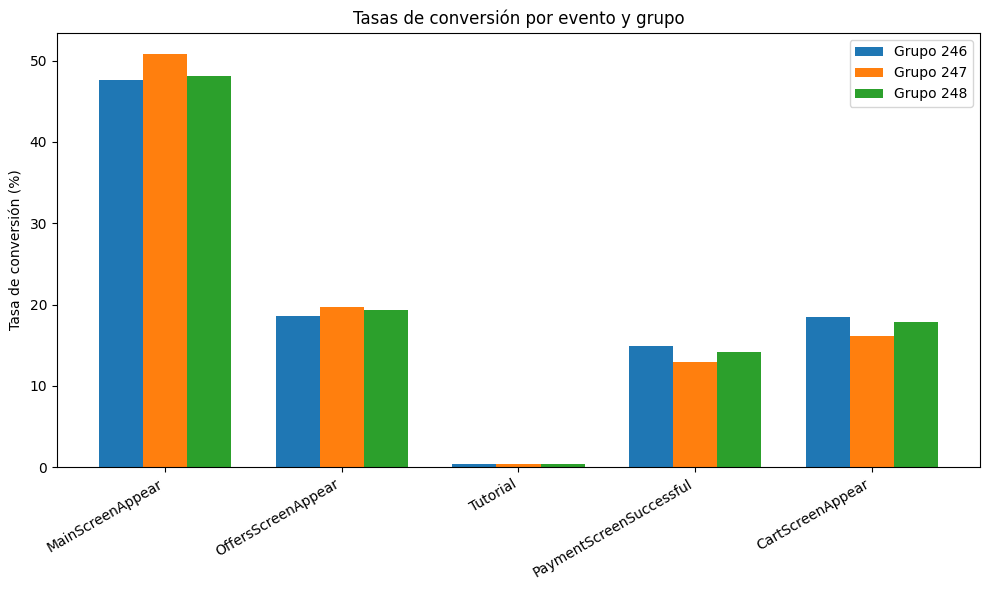

In [51]:
# Eventos
eventos = ['MainScreenAppear', 'OffersScreenAppear', 'Tutorial', 'PaymentScreenSuccessful', 'CartScreenAppear']

# Tasas de conversión (%) por grupo (de tus datos)
tasas_246 = [47.62, 18.62, 0.40, 14.88, 18.48]
tasas_247 = [50.87, 19.69, 0.44, 12.90, 16.11]
tasas_248 = [48.06, 19.38, 0.42, 14.24, 17.91]

x = np.arange(len(eventos))  # posiciones en x
width = 0.25  # ancho de las barras

fig, ax = plt.subplots(figsize=(10,6))
bars1 = ax.bar(x - width, tasas_246, width, label='Grupo 246')
bars2 = ax.bar(x, tasas_247, width, label='Grupo 247')
bars3 = ax.bar(x + width, tasas_248, width, label='Grupo 248')

ax.set_ylabel('Tasa de conversión (%)')
ax.set_title('Tasas de conversión por evento y grupo')
ax.set_xticks(x)
ax.set_xticklabels(eventos, rotation=30, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

La mayor tasa de conversion tanto en el grupo de control como en el de tratamiento se encuentra en Main Screen Apepear y la mejor en los tutoriales, lo que indica que la mayoria no sigue las instrucciones , sino que va directo a ver las ofertas , ve la pantalla de pago y finalmente cancela el valor . 

## Tabla Resumen de Resultados (Significancia con Bonferroni)

| Evento                 | Comparación   | Diferencia Significativa | Valor p    | Estadístico Z | Nivel α Ajustado |
|------------------------|--------------|--------------------------|------------|---------------|------------------|
| MainScreenAppear       | 246 vs 247   | Sí                       | 0.000000   | -12.8875      | 0.003333         |
| OffersScreenAppear     | 246 vs 247   | Sí                       | 0.000000   | -5.3918       | 0.003333         |
| Tutorial               | 246 vs 247   | No                       | 0.179921   | -1.341        | 0.003333         |
| PaymentScreenSuccessful| 246 vs 247   | Sí                       | 0.000000   | 11.4031       | 0.003333         |
| CartScreenAppear       | 246 vs 247   | Sí                       | 0.000000   | 12.4381       | 0.003333         |
| MainScreenAppear       | 246 vs 248   | No                       | 0.073365   | -1.7906       | 0.003333         |
| OffersScreenAppear     | 246 vs 248   | Sí                       | 0.000093   | -3.9075       | 0.003333         |
| Tutorial               | 246 vs 248   | No                       | 0.533734   | -0.6223       | 0.003333         |
| PaymentScreenSuccessful| 246 vs 248   | Sí                       | 0.000194   | 3.7262        | 0.003333         |
| CartScreenAppear       | 246 vs 248   | Sí                       | 0.002786   | 2.9904        | 0.003333         |
| MainScreenAppear       | 247 vs 248   | Sí                       | 0.000000   | 11.3164       | 0.003333         |
| OffersScreenAppear     | 247 vs 248   | No                       | 0.110119   | 1.5977        | 0.003333         |
| Tutorial               | 247 vs 248   | No                       | 0.456444   | 0.7447        | 0.003333         |
| PaymentScreenSuccessful| 247 vs 248   | Sí                       | 0.000000   | -7.8888       | 0.003333         |
| CartScreenAppear       | 247 vs 248   | Sí                       | 0.000000   | -9.6673       | 0.003333         |


## Conclusiones 

1. **Test A/A (Grupos 246 vs 247):**  
   Se observaron diferencias estadísticamente significativas en casi todos los eventos, salvo en el evento *Tutorial*. Esto indica una posible falla en la aleatorización o un sesgo en la asignación de usuarios, pues se esperaría que no haya diferencias entre grupos de control.

2. **Comparación Grupo 246 vs 248 (experimental):**  
   El grupo 248 mostró diferencias significativas en la mayoría de eventos (excepto *MainScreenAppear* y *Tutorial*), aunque las diferencias en tasas de conversión son pequeñas. Esto puede indicar que la modificación tiene cierto efecto, pero el impacto es limitado.

3. **Comparación Grupo 247 vs 248:**  
   También se encontraron diferencias significativas en algunos eventos, pero no en todos (*OffersScreenAppear* y *Tutorial* no mostraron diferencias significativas). Esto sugiere que el grupo 248 se comporta distinto respecto al grupo 247 en ciertos eventos.

4. **Eventos sin diferencias significativas consistentes:**  
   El evento *Tutorial* no mostró diferencias significativas en ninguna comparación, indicando que esta métrica es estable y no afectada por las modificaciones o sesgos.

5. **Implicación práctica:**  
   Dado que se detectan diferencias entre los grupos de control (246 vs 247), los resultados del experimento deben interpretarse con cautela, ya que puede existir un sesgo no controlado. Se recomienda revisar el proceso de asignación y considerar otras métricas o métodos para validar el test.
